In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

2023-04-06 17:05:31.396062: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
ltc = pd.read_csv('ltc_prediction_datawranglingStage.csv')

In [3]:
ltc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              1941 non-null   object 
 1   open              1941 non-null   float64
 2   high              1941 non-null   float64
 3   low               1941 non-null   float64
 4   close             1941 non-null   float64
 5   quoteAssetVolume  1941 non-null   float64
 6   numberofTrades    1941 non-null   float64
 7   TBQuoteVolume     1941 non-null   float64
dtypes: float64(7), object(1)
memory usage: 121.4+ KB


In [4]:
target = ltc['close'].values

In [5]:
ltc_features = ltc.drop('Date', axis=1)

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
ltc_scaled = scaler.fit_transform(ltc_features)

In [8]:
ltc_scaled_df = pd.DataFrame(ltc_scaled, columns=ltc_features.columns)
ltc_scaled_df['Date'] = ltc['Date']
ltc_scaled_df.set_index('Date', inplace=True)
print(ltc_scaled_df.head())

                open      high       low     close  quoteAssetVolume  \
Date                                                                   
2017-12-13  0.682570  0.785775  0.736581  0.731877          0.001496   
2017-12-14  0.731951  0.715778  0.711789  0.683593          0.001426   
2017-12-15  0.683666  0.745260  0.674569  0.742816          0.002767   
2017-12-16  0.742892  0.721628  0.814057  0.742734          0.001431   
2017-12-17  0.740177  0.782696  0.829552  0.790524          0.002740   

            numberofTrades  TBQuoteVolume  
Date                                       
2017-12-13        0.001815       0.001196  
2017-12-14        0.002385       0.001265  
2017-12-15        0.003517       0.003228  
2017-12-16        0.002603       0.001082  
2017-12-17        0.004914       0.003179  


In [9]:
seq_len = 1
train_size = int(len(ltc_scaled_df) * 0.9)
train_data = ltc_scaled_df.iloc[:train_size]
test_data = ltc_scaled_df.iloc[train_size:]

In [10]:
def create_sequences(data, seq_len):
    if len(data) < seq_len:
        raise ValueError("Length of data is less than sequence length")
    X = []
    y = []
    for i in range(seq_len, len(data)):
        X.append(data.iloc[i-seq_len:i].values)
        y.append(data.iloc[i].values)
    X = np.array(X)
    y = np.array(y)
    return X, y

In [11]:
input_cols = ['open', 'high', 'low', 'close',]
X_train, y_train = create_sequences(train_data[input_cols], seq_len)
X_test, y_test = create_sequences(test_data[input_cols], seq_len)

In [12]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='Adam')

In [13]:
model.fit(X_train, y_train, epochs=15, batch_size=32, verbose=1)

Epoch 1/15
55/55 [==============================] - 2s 3ms/step - loss: 0.0274
Epoch 2/15
55/55 [==============================] - 0s 3ms/step - loss: 0.0010
Epoch 3/15
55/55 [==============================] - 0s 3ms/step - loss: 6.2653e-04
Epoch 4/15
55/55 [==============================] - 0s 3ms/step - loss: 5.1682e-04
Epoch 5/15
55/55 [==============================] - 0s 3ms/step - loss: 4.8796e-04
Epoch 6/15
55/55 [==============================] - 0s 3ms/step - loss: 4.6831e-04
Epoch 7/15
55/55 [==============================] - 0s 3ms/step - loss: 4.7887e-04
Epoch 8/15
55/55 [==============================] - 0s 3ms/step - loss: 4.7655e-04
Epoch 9/15
55/55 [==============================] - 0s 3ms/step - loss: 4.7257e-04
Epoch 10/15
55/55 [==============================] - 0s 3ms/step - loss: 4.7743e-04
Epoch 11/15
55/55 [==============================] - 0s 3ms/step - loss: 4.7262e-04
Epoch 12/15
55/55 [==============================] - 0s 3ms/step - loss: 4.7432e-04
Epoch 13/

In [14]:
test_loss = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', test_loss)

Test loss: 0.00011687169899232686


In [15]:
y_pred = model.predict(X_test)

7/7 [==============================] - 1s 1ms/step


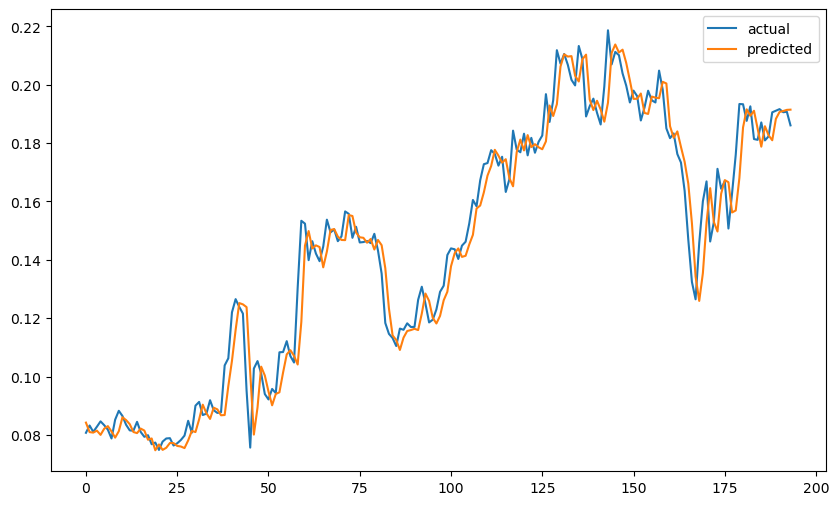

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(y_test[:, 3], label='actual')
plt.plot(y_pred[:, 0], label='predicted')
plt.legend()
plt.show()